Importing Libraries to be used in the notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re


# Loading Dataset

In [2]:
# Importing train and test data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test_with_no_labels.csv')
display(train_df.head())
display(test_df.head())


,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


# Exploratory Data Analysis 

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


The dataset contains three features
- the dataset consist of `15819` rows
- there seems to be no null values


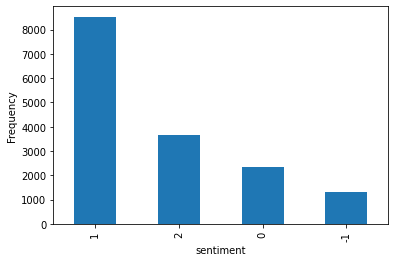

In [45]:
train_df.sentiment.value_counts().plot(kind='bar')
plt.ylabel('Frequency')
plt.xlabel('sentiment');

Most tweets support the man-made climate change which is represented by `1` while we have a fewer anti-climate change tweets

# Data Cleaning and Wrangling 

### Creating a function to clean the `message`

In [8]:
train_df.message[3]

'#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD'

In [41]:
# creating a function
def cleaning(tweet):
    rem_link = re.sub(pattern, '', tweet)
    rem_punct = re.sub(r'[^a-zA-Z ]', '', rem_link)
    rem_punct = re.sub(r'RT', '', rem_punct)
    word_split = rem_punct.lower().split()
    return word_split

In [42]:
train_df['cleaning'] = train_df.message.apply(cleaning)

In [43]:
train_df.head()

,sentiment,message,tweetid,cleaning
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,"[polyscimajor, epa, chief, doesnt, think, carb..."
1,1,It's not like we lack evidence of anthropogeni...,126103,"[its, not, like, we, lack, evidence, of, anthr..."
2,2,RT @RawStory: Researchers say we have three ye...,698562,"[rawstory, researchers, say, we, have, three, ..."
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,"[todayinmaker, wired, was, a, pivotal, year, i..."
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,"[soynoviodetodas, its, and, a, racist, sexist,..."


In [ ]:
# vectorize